In [1]:
from google.colab import files
uploaded = files.upload()

Saving listingsLA.csv to listingsLA.csv


In [65]:
import pandas as pd
from sklearn.utils import resample
import io

listings = pd.read_csv(io.BytesIO(uploaded['listingsLA.csv']))
print(listings)

                        id                                       listing_url  \
0       670339032744709144   https://www.airbnb.com/rooms/670339032744709144   
1                 37014494             https://www.airbnb.com/rooms/37014494   
2      1024835174766068422  https://www.airbnb.com/rooms/1024835174766068422   
3       850744632375448560   https://www.airbnb.com/rooms/850744632375448560   
4       953950676345326970   https://www.airbnb.com/rooms/953950676345326970   
...                    ...                                               ...   
45528   892894292387453414   https://www.airbnb.com/rooms/892894292387453414   
45529   944430003646575559   https://www.airbnb.com/rooms/944430003646575559   
45530   746345243817423719   https://www.airbnb.com/rooms/746345243817423719   
45531             32943553             https://www.airbnb.com/rooms/32943553   
45532             37853838             https://www.airbnb.com/rooms/37853838   

            scrape_id last_scraped     

# Data Cleaning

Checking all the attributes in the daatset


In [67]:
print(listings.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

Removing unnecessary attributes from the daatset

In [68]:
#Before Dropping
print(listings.shape)

listings = listings.drop(['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'calendar_updated','license','calendar_last_scraped'], axis=1)

#After dropping
print(listings.shape)

(45533, 75)
(45533, 59)


Price column has \$ symbol and cannot be processed as a numerical column. So, removing the \$ sign and converting it to float

In [69]:
# Ensure that the 'price' column is treated as a string first
listings['price'] = listings['price'].astype(str)

# Remove the $ symbol and commas using regex, then convert to numeric
listings['price'] = listings['price'].str.replace(r'[$,]', '', regex=True)

# Convert the cleaned 'price' column to a numeric type
listings['price'] = pd.to_numeric(listings['price'], errors='coerce')

# Check the result
print(listings['price'].head())
print(listings['price'].dtype)

0    399.0
1      NaN
2    434.0
3     49.0
4    231.0
Name: price, dtype: float64
float64


Checking if any of the numerical attributes have string or text data

In [70]:
# Convert the specified columns to numeric, coerce errors to NaN
cols_to_check = ['price','minimum_nights','maximum_nights','number_of_reviews','bedrooms', 'bathrooms', 'beds', 'accommodates',
                 'availability_30', 'availability_365', 'number_of_reviews_ltm','review_scores_rating']

# Function to check if values are non-numeric
def count_non_numeric(series):
    # This will return True for non-numeric values (strings or text)
    return series.apply(pd.to_numeric, errors='coerce').isna().sum()

# Apply the function to each column and get the count of non-numeric rows per column
non_numeric_counts = listings[cols_to_check].apply(count_non_numeric)

# Output the result
print("Number of rows with non-numeric values for each column:")
print(non_numeric_counts)



Number of rows with non-numeric values for each column:
price                     8237
minimum_nights               0
maximum_nights               0
number_of_reviews            0
bedrooms                  3039
bathrooms                 8239
beds                      8334
accommodates                 0
availability_30              0
availability_365             0
number_of_reviews_ltm        0
review_scores_rating     12146
dtype: int64


Cleaning the text attributes room_type

In [71]:
# Remove leading/trailing spaces
listings['room_type'] = listings['room_type'].str.strip()

# Standardize text to lowercase
listings['room_type'] = listings['room_type'].str.lower()


Checking for missing values in the text attributes room_type and neighbourhood_cleansed

In [72]:
import pandas as pd

# Specify the columns to check for missing values
columns_to_check = ['room_type', 'neighbourhood_cleansed']

# Get the count of missing values for the specified columns
missing_values = listings[columns_to_check].isnull().sum()

# Display the number of missing values for these columns
print(missing_values)


room_type                 0
neighbourhood_cleansed    0
dtype: int64


Converting the amenities in each row into a numerical attribute in order to be used for further analysis.

In [73]:
# Function to clean and count the number of amenities in each record
def count_amenities(amenities_str):
    # Decode special characters and remove unnecessary characters like quotes, square brackets, etc.
    cleaned_amenities_str = amenities_str.encode('utf-8').decode('unicode_escape').strip('[]').replace('"', '')

    # Split the cleaned string into a list of amenities
    amenities_list = cleaned_amenities_str.split(', ')

    # Return the count of amenities
    return len(amenities_list)

# Apply the function to each record in the 'amenities' column
listings['amenities_count'] = listings['amenities'].apply(lambda x: count_amenities(x))

# Display the updated DataFrame with the new column
print(listings[['amenities', 'amenities_count']])

                                               amenities  amenities_count
0      ["Dedicated workspace", "Air conditioning", "K...               14
1      ["Air conditioning", "Pets allowed", "Hot wate...               14
2      ["Air conditioning", "Kitchen", "Carbon monoxi...               11
3      ["Dedicated workspace", "Air conditioning", "K...                9
4      ["Clothing storage: closet", "Shared beach acc...               48
...                                                  ...              ...
45528  ["Pool", "Air conditioning", "Fire pit", "Kitc...               13
45529            ["Wifi", "Air conditioning", "Heating"]                3
45530  ["Air conditioning", "TV", "Free parking on pr...                5
45531  ["Free street parking", "Kitchen", "Room-darke...               47
45532  ["Free street parking", "Mountain view", "Kitc...               66

[45533 rows x 2 columns]


# Task 1: Descriptive Statistics

Calculate summary statistics for numerical features such as `price`,
`minimum_nights`, `maximum_nights`, `number_of_reviews`, and
`review_scores_rating`. Understand the central tendency, dispersion, and
distribution of these variables.

In [74]:
# List of numerical features to analyze
numerical_features = ['price','minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating']

# Additional features for analysis
additional_numerical_features = ['accommodates','availability_30', 'availability_365', 'number_of_reviews_ltm']

Removing null values from the required numerical features

In [75]:
# Convert columns to numeric, invalid parsing will be set as NaN
listings[numerical_features] = listings[numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
listings_1 = listings.dropna(subset=numerical_features)

# Check the DataFrame to ensure non-numeric values have been removed
print(listings_1)

# Verify that all specified columns are numerical
print(listings_1[numerical_features].dtypes)

                        id                                               name  \
3       850744632375448560                   Tianpu's warm room with bathroom   
4       953950676345326970  Santa Monica apt, free parking, steps to the b...   
6                  5694422                             2 Bedroom Modern Oasis   
7       873326033487284509           Luxury Waterfront Retreat | Rooftop View   
8       908697518167341476        Modern, Resort-Style Home in West Hollywood   
...                    ...                                                ...   
45520   560162340399438701   Colorful Oasis- central to everywhere you’ll go!   
45521  1064680221580507438                      Private Guest Suite, Pets OK!   
45523   726757690178675328             Condo w/Front Desk Security, L.A. Live   
45531             32943553       Charming Craftsman Bungalow w/ Outdoor Sauna   
45532             37853838                   Views, big backyard, central LA!   

                           

Calculating the summary statistics for the required numerical values

In [76]:
# Calculate summary statistics for the numerical features
summary_statistics = listings_1[numerical_features].describe()

# Display the summary statistics
print("Summary Statistics:")
print(summary_statistics)

Summary Statistics:
              price  minimum_nights  maximum_nights  number_of_reviews  \
count  28132.000000    28132.000000    28132.000000       28132.000000   
mean     244.981018       13.977286      451.368939          54.310643   
std      467.988249       19.947104      413.572911          94.806602   
min        5.000000        1.000000        1.000000           1.000000   
25%       96.000000        2.000000       90.000000           4.000000   
50%      151.000000        3.000000      365.000000          17.000000   
75%      250.000000       30.000000      730.000000          62.000000   
max    20343.000000      700.000000     3650.000000        3024.000000   

       review_scores_rating  
count          28132.000000  
mean               4.783280  
std                0.409133  
min                1.000000  
25%                4.750000  
50%                4.900000  
75%                5.000000  
max                5.000000  


Removing null values from the additional numerical features

In [77]:
# Convert columns to numeric, invalid parsing will be set as NaN
listings[additional_numerical_features] = listings[additional_numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
listings_2 = listings.dropna(subset=additional_numerical_features)

# Check the DataFrame to ensure non-numeric values have been removed
print(listings_2)

# Verify that all specified columns are numerical
print(listings_2[additional_numerical_features].dtypes)

                        id                                               name  \
0       670339032744709144     Westwood lovely three bedrooms three bathrooms   
1                 37014494      Spanish style lower duplex near Beverly Hills   
2      1024835174766068422                        Charming Beverly Hills Home   
3       850744632375448560                   Tianpu's warm room with bathroom   
4       953950676345326970  Santa Monica apt, free parking, steps to the b...   
...                    ...                                                ...   
45528   892894292387453414                       Cozy 1 Bed, 2 Bath apartment   
45529   944430003646575559                   DTLA Loft | Industrial | Central   
45530   746345243817423719   Long Beach, Rustic Suite 3 Beds, 1 Bath, 2 Rooms   
45531             32943553       Charming Craftsman Bungalow w/ Outdoor Sauna   
45532             37853838                   Views, big backyard, central LA!   

                           

Calculating the summary statistics for the additional numerical features

In [78]:
# Calculate summary statistics for the numerical features
summary_statistics = listings_2[additional_numerical_features].describe()

# Display the summary statistics
print("Summary Statistics:")
print(summary_statistics)

Summary Statistics:
       accommodates  availability_30  availability_365  number_of_reviews_ltm
count  45533.000000     45533.000000      45533.000000           45533.000000
mean       4.019876        14.763029        195.093449               8.459864
std        2.861610        12.276144        133.394403              16.361008
min        1.000000         0.000000          0.000000               0.000000
25%        2.000000         0.000000         75.000000               0.000000
50%        3.000000        15.000000        202.000000               1.000000
75%        6.000000        29.000000        335.000000               9.000000
max       16.000000        30.000000        365.000000             543.000000


Calculating the values variance, skewness, kurtosis for understanding the central tendency, dispersion

In [79]:
# Calculate variance
variance_values1 = listings_1[numerical_features].var()
variance_values2 = listings_2[additional_numerical_features].var()
print("\nVariance Values:")
print(variance_values1)
print(variance_values2)

# Calculate skewness
skewness_values1 = listings_1[numerical_features].skew()
skewness_values2 = listings_2[additional_numerical_features].skew()
print("\nSkewness Values:")
print(skewness_values1)
print(skewness_values2)

# Calculate kurtosis
kurtosis_values1 = listings_1[numerical_features].kurt()
kurtosis_values2 = listings_2[additional_numerical_features].kurt()
print("\nKurtosis Values:")
print(kurtosis_values1)
print(kurtosis_values2)


Variance Values:
price                   219013.001239
minimum_nights             397.886975
maximum_nights          171042.552550
number_of_reviews         8988.291717
review_scores_rating         0.167390
dtype: float64
accommodates                 8.188813
availability_30            150.703705
availability_365         17794.066709
number_of_reviews_ltm      267.682595
dtype: float64

Skewness Values:
price                   16.954021
minimum_nights           9.941413
maximum_nights           0.781626
number_of_reviews        4.603197
review_scores_rating    -5.218519
dtype: float64
accommodates             1.569313
availability_30          0.004477
availability_365        -0.151872
number_of_reviews_ltm    3.647759
dtype: float64

Kurtosis Values:
price                   489.571134
minimum_nights          233.096220
maximum_nights           -0.735168
number_of_reviews        52.867902
review_scores_rating     37.054783
dtype: float64
accommodates              2.759567
availability_

# 2. Distribution Analysis

Plot histograms or density plots for key numerical features like price,minimum_nights, and review_scores_rating. Analyze the distribution of these features to identify any skewness or outliers.

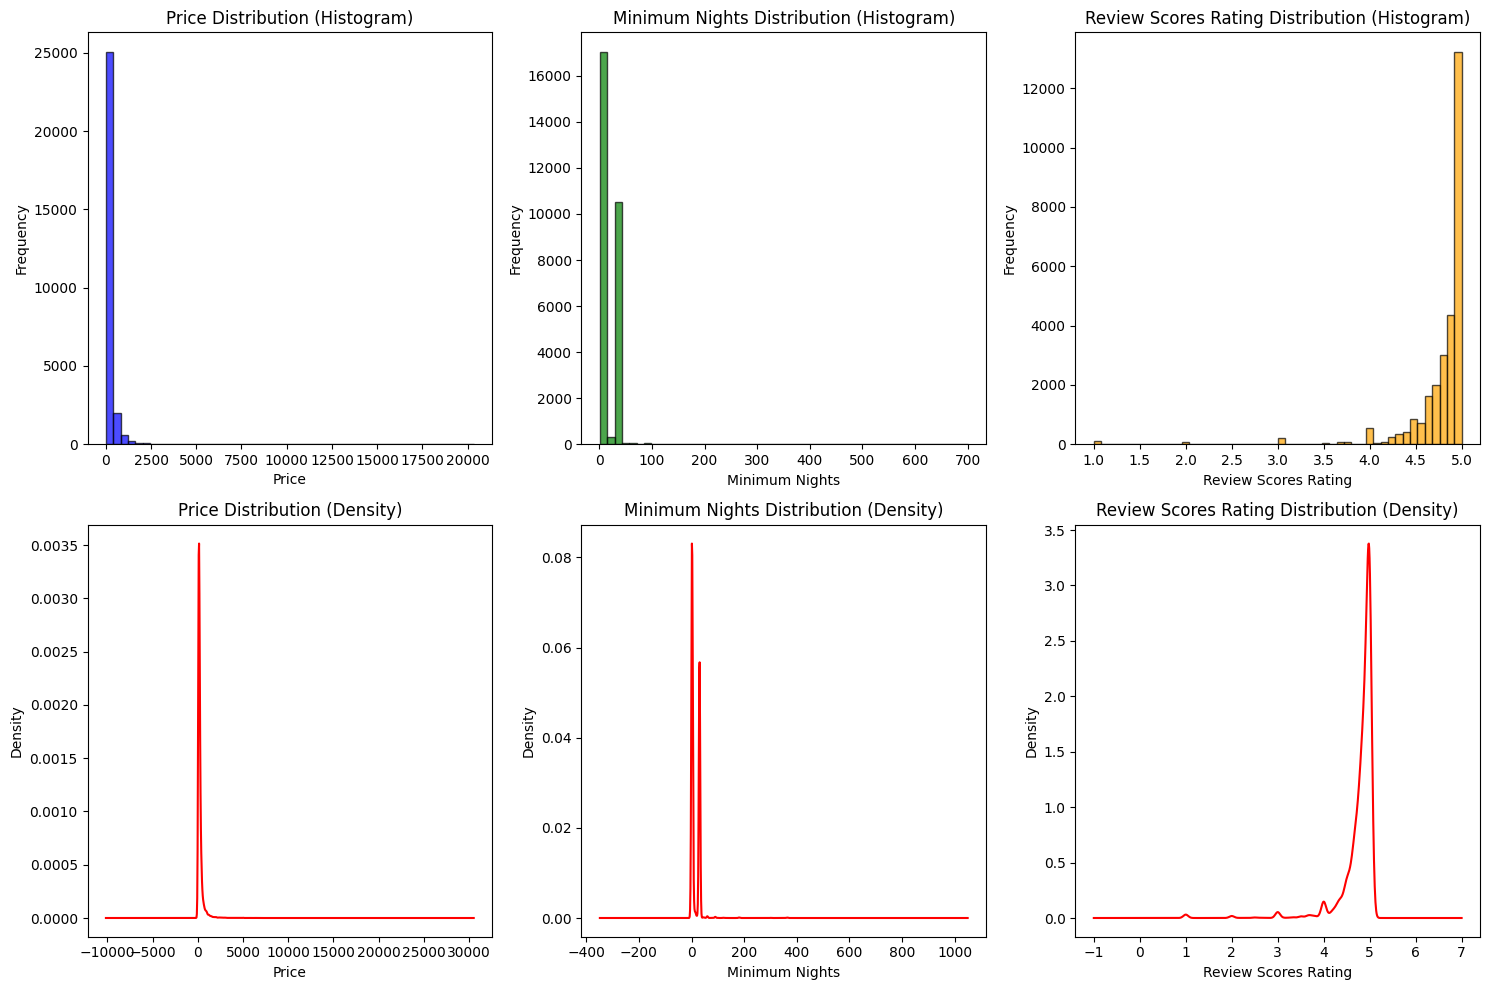

In [80]:
import matplotlib.pyplot as plt

# Plot histograms and density plots for key numerical features
plt.figure(figsize=(15, 10))

# Price histogram
plt.subplot(2, 3, 1)
plt.hist(listings_1['price'], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('Price Distribution (Histogram)')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Price density plot
plt.subplot(2, 3, 4)
listings_1['price'].plot(kind='kde', color='red')
plt.title('Price Distribution (Density)')
plt.xlabel('Price')
plt.ylabel('Density')

# Minimum nights histogram
plt.subplot(2, 3, 2)
plt.hist(listings_1['minimum_nights'], bins=50, color='green', edgecolor='black', alpha=0.7)
plt.title('Minimum Nights Distribution (Histogram)')
plt.xlabel('Minimum Nights')
plt.ylabel('Frequency')

# Minimum nights density plot
plt.subplot(2, 3, 5)
listings_1['minimum_nights'].plot(kind='kde', color='red')
plt.title('Minimum Nights Distribution (Density)')
plt.xlabel('Minimum Nights')
plt.ylabel('Density')

# Review scores rating histogram
plt.subplot(2, 3, 3)
plt.hist(listings_1['review_scores_rating'].dropna(), bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.title('Review Scores Rating Distribution (Histogram)')
plt.xlabel('Review Scores Rating')
plt.ylabel('Frequency')

# Review scores rating density plot
plt.subplot(2, 3, 6)
listings_1['review_scores_rating'].dropna().plot(kind='kde', color='red')
plt.title('Review Scores Rating Distribution (Density)')
plt.xlabel('Review Scores Rating')
plt.ylabel('Density')

# Show the plot
plt.tight_layout()
plt.show()

# 3. Correlation Analysis

Create a correlation matrix to explore relationships between numerical variables such as price, number_of_reviews, availability_365, and review_scores_rating. Identify any strong correlations that might be useful for predictive modeling or further investigation.

Plotting correlation matrix and heatmap for the required attributes

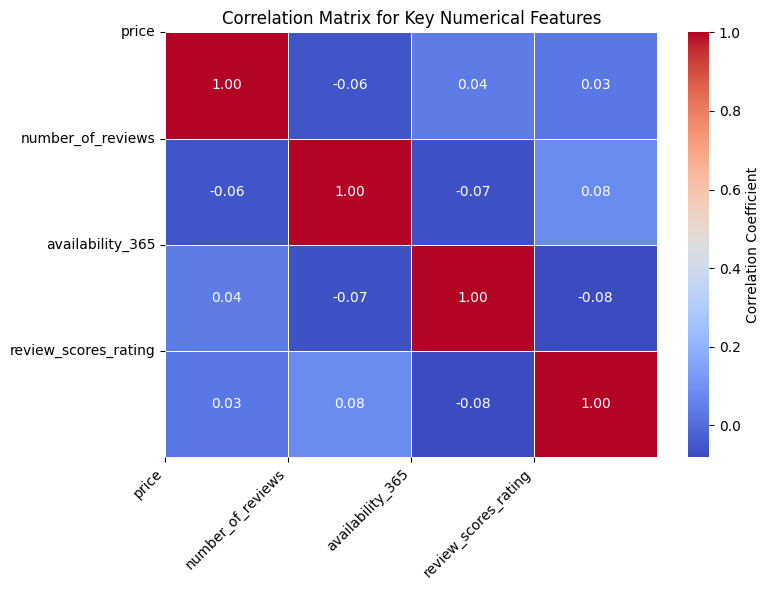

,price,number_of_reviews,availability_365,review_scores_rating
price,1.000000,-0.059618,0.039467,0.032659
number_of_reviews,-0.059618,1.000000,-0.068207,0.081331
availability_365,0.039467,-0.068207,1.000000,-0.081188
review_scores_rating,0.032659,0.081331,-0.081188,1.000000


In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#List of columns
correlation_columns = ['price', 'number_of_reviews', 'availability_365', 'review_scores_rating']

# Convert columns to numeric, invalid parsing will be set as NaN
listings[correlation_columns] = listings[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns
listings_3 = listings_1.dropna(subset=correlation_columns)

# Creating the correlation matrix
correlation_matrix = listings_3[correlation_columns].corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix

Plotting correlation matrix and heatmap for additional attributes

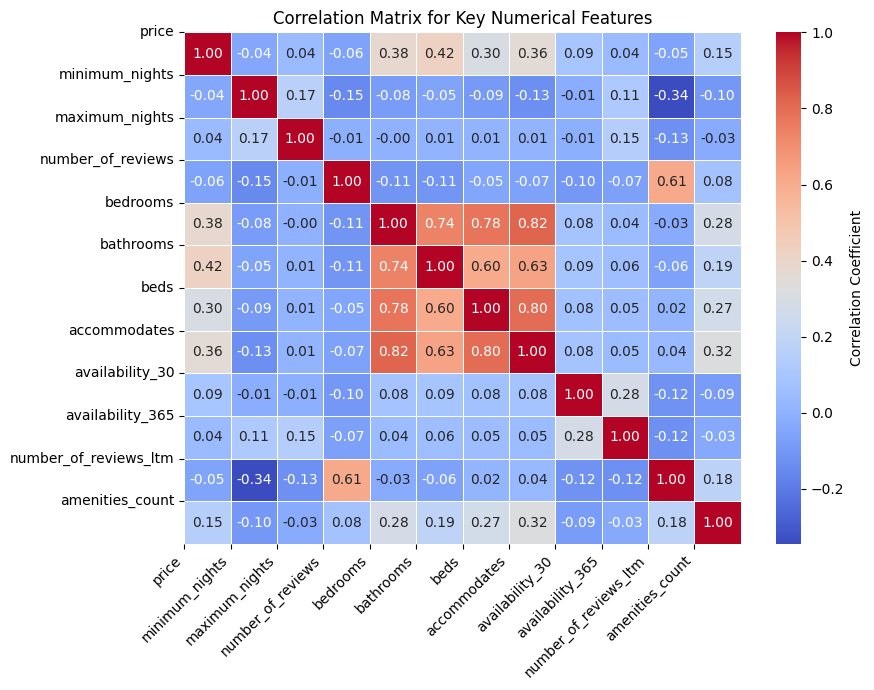

,price,minimum_nights,maximum_nights,number_of_reviews,bedrooms,bathrooms,beds,accommodates,availability_30,availability_365,number_of_reviews_ltm,amenities_count
price,1.000000,-0.041617,0.040243,-0.059728,0.378780,0.420554,0.296491,0.359060,0.094450,0.039388,-0.054364,0.149384
minimum_nights,-0.041617,1.000000,0.165000,-0.148454,-0.084183,-0.050948,-0.088118,-0.133273,-0.014618,0.113197,-0.344487,-0.102880
maximum_nights,0.040243,0.165000,1.000000,-0.010160,-0.002983,0.010494,0.009006,0.009823,-0.012075,0.148143,-0.125530,-0.025569
number_of_reviews,-0.059728,-0.148454,-0.010160,1.000000,-0.110737,-0.105418,-0.048085,-0.065821,-0.102577,-0.068447,0.610400,0.079560
bedrooms,0.378780,-0.084183,-0.002983,-0.110737,1.000000,0.735190,0.775231,0.817127,0.084548,0.044845,-0.028666,0.281478
bathrooms,0.420554,-0.050948,0.010494,-0.105418,0.735190,1.000000,0.604596,0.627461,0.090797,0.059261,-0.061310,0.190498
beds,0.296491,-0.088118,0.009006,-0.048085,0.775231,0.604596,1.000000,0.797546,0.075328,0.050469,0.016014,0.271292
accommodates,0.359060,-0.133273,0.009823,-0.065821,0.817127,0.627461,0.797546,1.000000,0.084794,0.045602,0.036571,0.322140
availability_30,0.094450,-0.014618,-0.012075,-0.102577,0.084548,0.090797,0.075328,0.084794,1.000000,0.282468,-0.116373,-0.086447
availability_365,0.039388,0.113197,0.148143,-0.068447,0.044845,0.059261,0.050469,0.045602,0.282468,1.000000,-0.124124,-0.032829


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#List of columns
correlation_columns = ['price','minimum_nights','maximum_nights','number_of_reviews','bedrooms','bathrooms','beds','accommodates','availability_30','availability_365','number_of_reviews_ltm','amenities_count']

# Convert columns to numeric, invalid parsing will be set as NaN
listings[correlation_columns] = listings[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns
listings_4 = listings_1.dropna(subset=correlation_columns)

# Creating the correlation matrix
correlation_matrix = listings_4[correlation_columns].corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix


# 4. Price Analysis

Analyze the distribution of prices across different neighborhoods (host_neighbourhood) or room types (if available). Understand which neighborhoods have higher or lower average prices and whether certain neighborhoods are more popular for shortterm or longterm stays.

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

listings['stay_type'] = listings['minimum_nights'].apply(lambda x: 'Long-term' if x > 30 else 'Short-term')

# Extracting relevant columns for price analysis: price, neighbourhood_cleansed, room_type, and minimum_nights
price_analysis_columns = ['price', 'neighbourhood_cleansed', 'room_type', 'minimum_nights', 'maximum_nights', 'stay_type']

# Creating the price_analysis_data DataFrame
price_analysis_data = listings[price_analysis_columns].dropna()

# Calculating average price per neighborhood
avg_price_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

# Calculating average minimum/maximum nights per neighborhood (to understand short-term vs long-term stays)
avg_minimum_nights_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['minimum_nights'].mean().sort_values(ascending=False)
avg_maximum_nights_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['maximum_nights'].mean().sort_values(ascending=False)

# Calculating average price per room type
avg_price_room_type = price_analysis_data.groupby('room_type')['price'].mean().sort_values(ascending=False)

# Calculate average price for short-term and long-term stays by neighborhood
avg_price_neighbourhood_stay_type = price_analysis_data.groupby(['neighbourhood_cleansed', 'stay_type'])['price'].mean().unstack().fillna(0)

# Calculate average price for short-term and long-term stays by room type
avg_price_room_type_stay_type = price_analysis_data.groupby(['room_type', 'stay_type'])['price'].mean().unstack().fillna(0)

# Displaying the results
print("Average Price by Neighborhood:")
print(avg_price_neighbourhood)

print("\nAverage Minimum Nights by Neighborhood:")
print(avg_minimum_nights_neighbourhood)

print("\nAverage Maximum Nights by Neighborhood:")
print(avg_maximum_nights_neighbourhood)

print("\nAverage Price by Room Type:")
print(avg_price_room_type)

print("\nAverage Price by Neighborhood and Stay Type:")
print(avg_price_neighbourhood_stay_type)

print("\nAverage Price by Room Type and Stay Type:")
print(avg_price_room_type_stay_type)





Average Price by Neighborhood:
neighbourhood_cleansed
Bel-Air                 2680.753425
Malibu                  1652.170316
Beverly Crest           1521.540107
Hollywood Hills West    1144.069149
Rancho Palos Verdes      899.468750
                           ...     
Irwindale                 73.800000
Sun Village               58.000000
Central-Alameda           54.430556
South Park                50.588235
Watts                     37.391304
Name: price, Length: 265, dtype: float64

Average Minimum Nights by Neighborhood:
neighbourhood_cleansed
Santa Fe Springs                  54.214286
Cheviot Hills                     45.578947
La Habra Heights                  42.416667
Industry                          39.625000
Porter Ranch                      35.043478
                                    ...    
Val Verde                          1.000000
Lake Los Angeles                   1.000000
Unincorporated Catalina Island     1.000000
Hasley Canyon                      1.000000
Sun V

<ipython-input-84-c39fbfb5b17b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_neighbourhood.values, y=avg_price_neighbourhood.index, palette='crest')
<ipython-input-84-c39fbfb5b17b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_minimum_nights_neighbourhood.values, y=avg_minimum_nights_neighbourhood.index, palette='rocket')
<ipython-input-84-c39fbfb5b17b>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_maximum_nights_neighbourhood.values, y=avg_maximum_nights_neighbourhood.index, palette='mako')


Text(0, 0.5, 'Neighborhood')

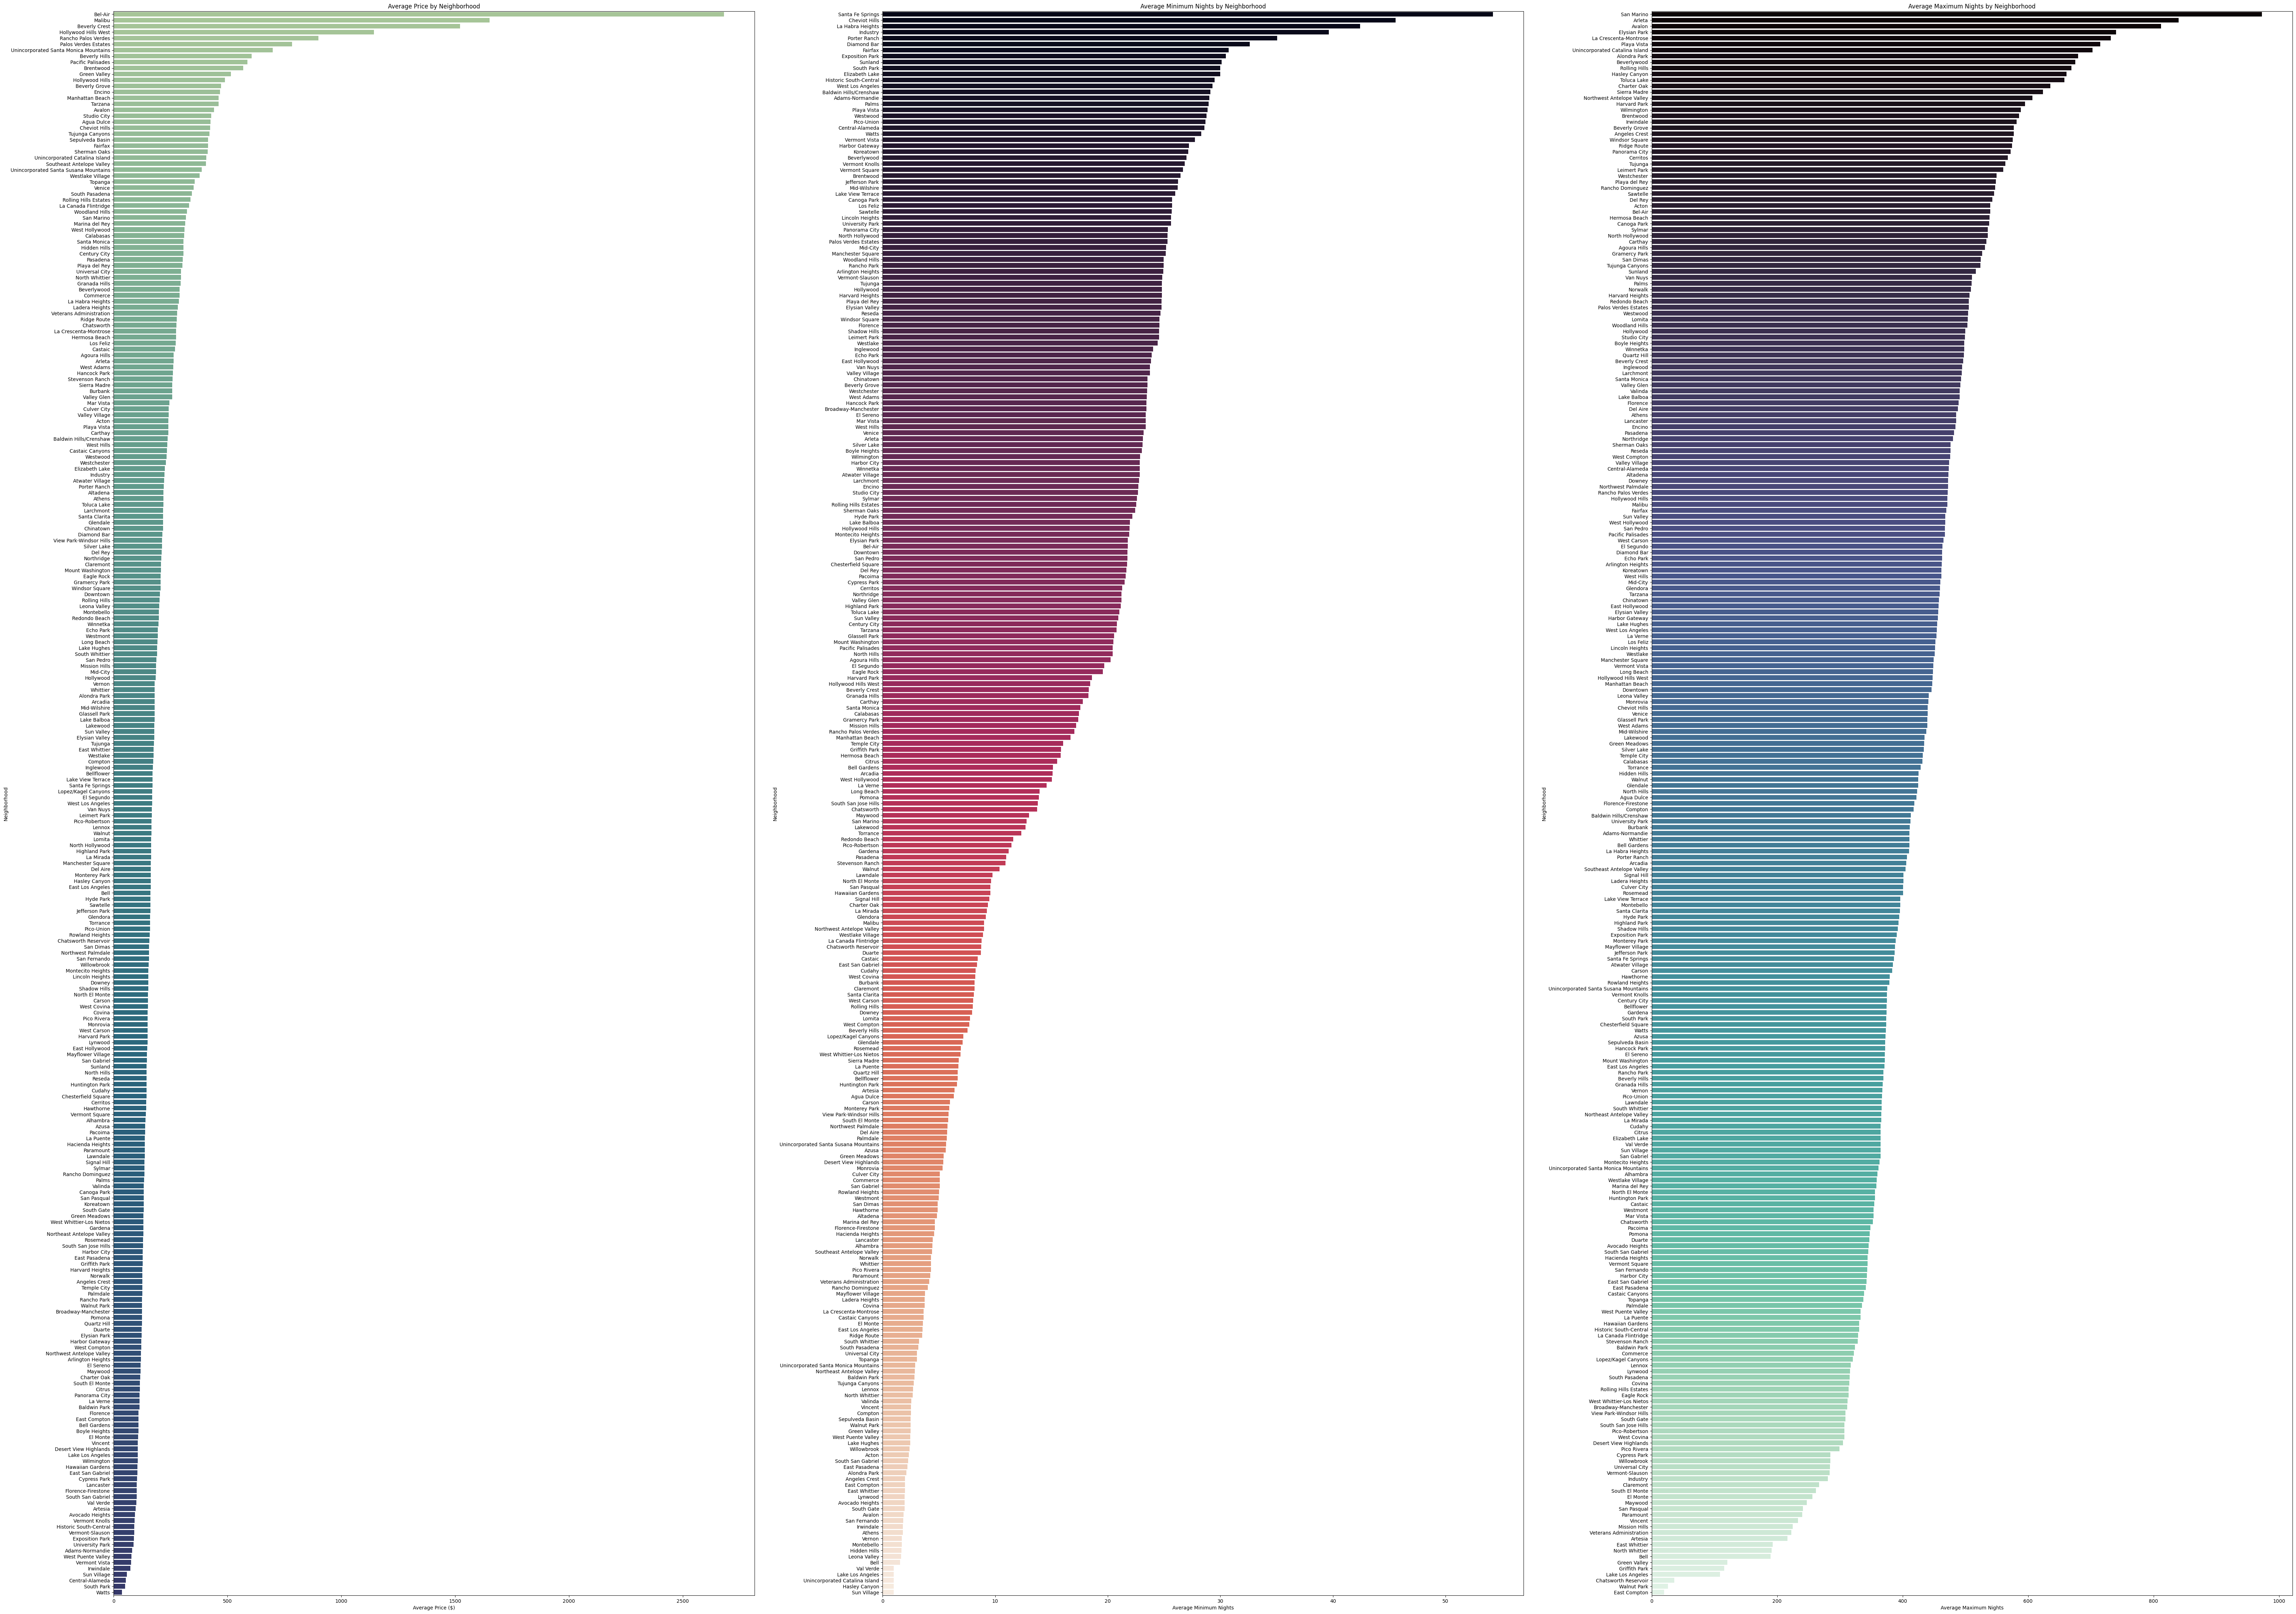

In [84]:
# Plotting price and minimum nights distributions across neighborhoods and room types
plt.figure(figsize=(80, 199))

# Average price by neighborhood
plt.subplot(3, 3, 1)
sns.barplot(x=avg_price_neighbourhood.values, y=avg_price_neighbourhood.index, palette='crest')
plt.title('Average Price by Neighborhood')
plt.xlabel('Average Price ($)')
plt.ylabel('Neighborhood')

# Average minimum nights by neighborhood
plt.subplot(3, 3, 2)
sns.barplot(x=avg_minimum_nights_neighbourhood.values, y=avg_minimum_nights_neighbourhood.index, palette='rocket')
plt.title('Average Minimum Nights by Neighborhood')
plt.xlabel('Average Minimum Nights')
plt.ylabel('Neighborhood')

# Average maximum nights by neighborhood
plt.subplot(3, 3, 3)
sns.barplot(x=avg_maximum_nights_neighbourhood.values, y=avg_maximum_nights_neighbourhood.index, palette='mako')
plt.title('Average Maximum Nights by Neighborhood')
plt.xlabel('Average Maximum Nights')
plt.ylabel('Neighborhood')


<ipython-input-85-9fcc39e8ef42>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_room_type.values, y=avg_price_room_type.index, palette='pastel')


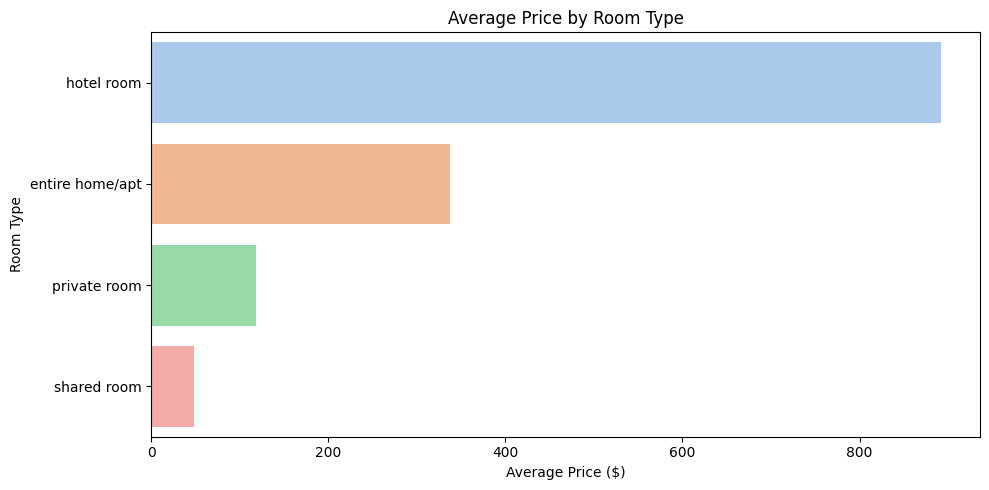

In [85]:
# Average price by room type
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_price_room_type.values, y=avg_price_room_type.index, palette='pastel')
plt.title('Average Price by Room Type')
plt.xlabel('Average Price ($)')
plt.ylabel('Room Type')

plt.tight_layout()
plt.show()

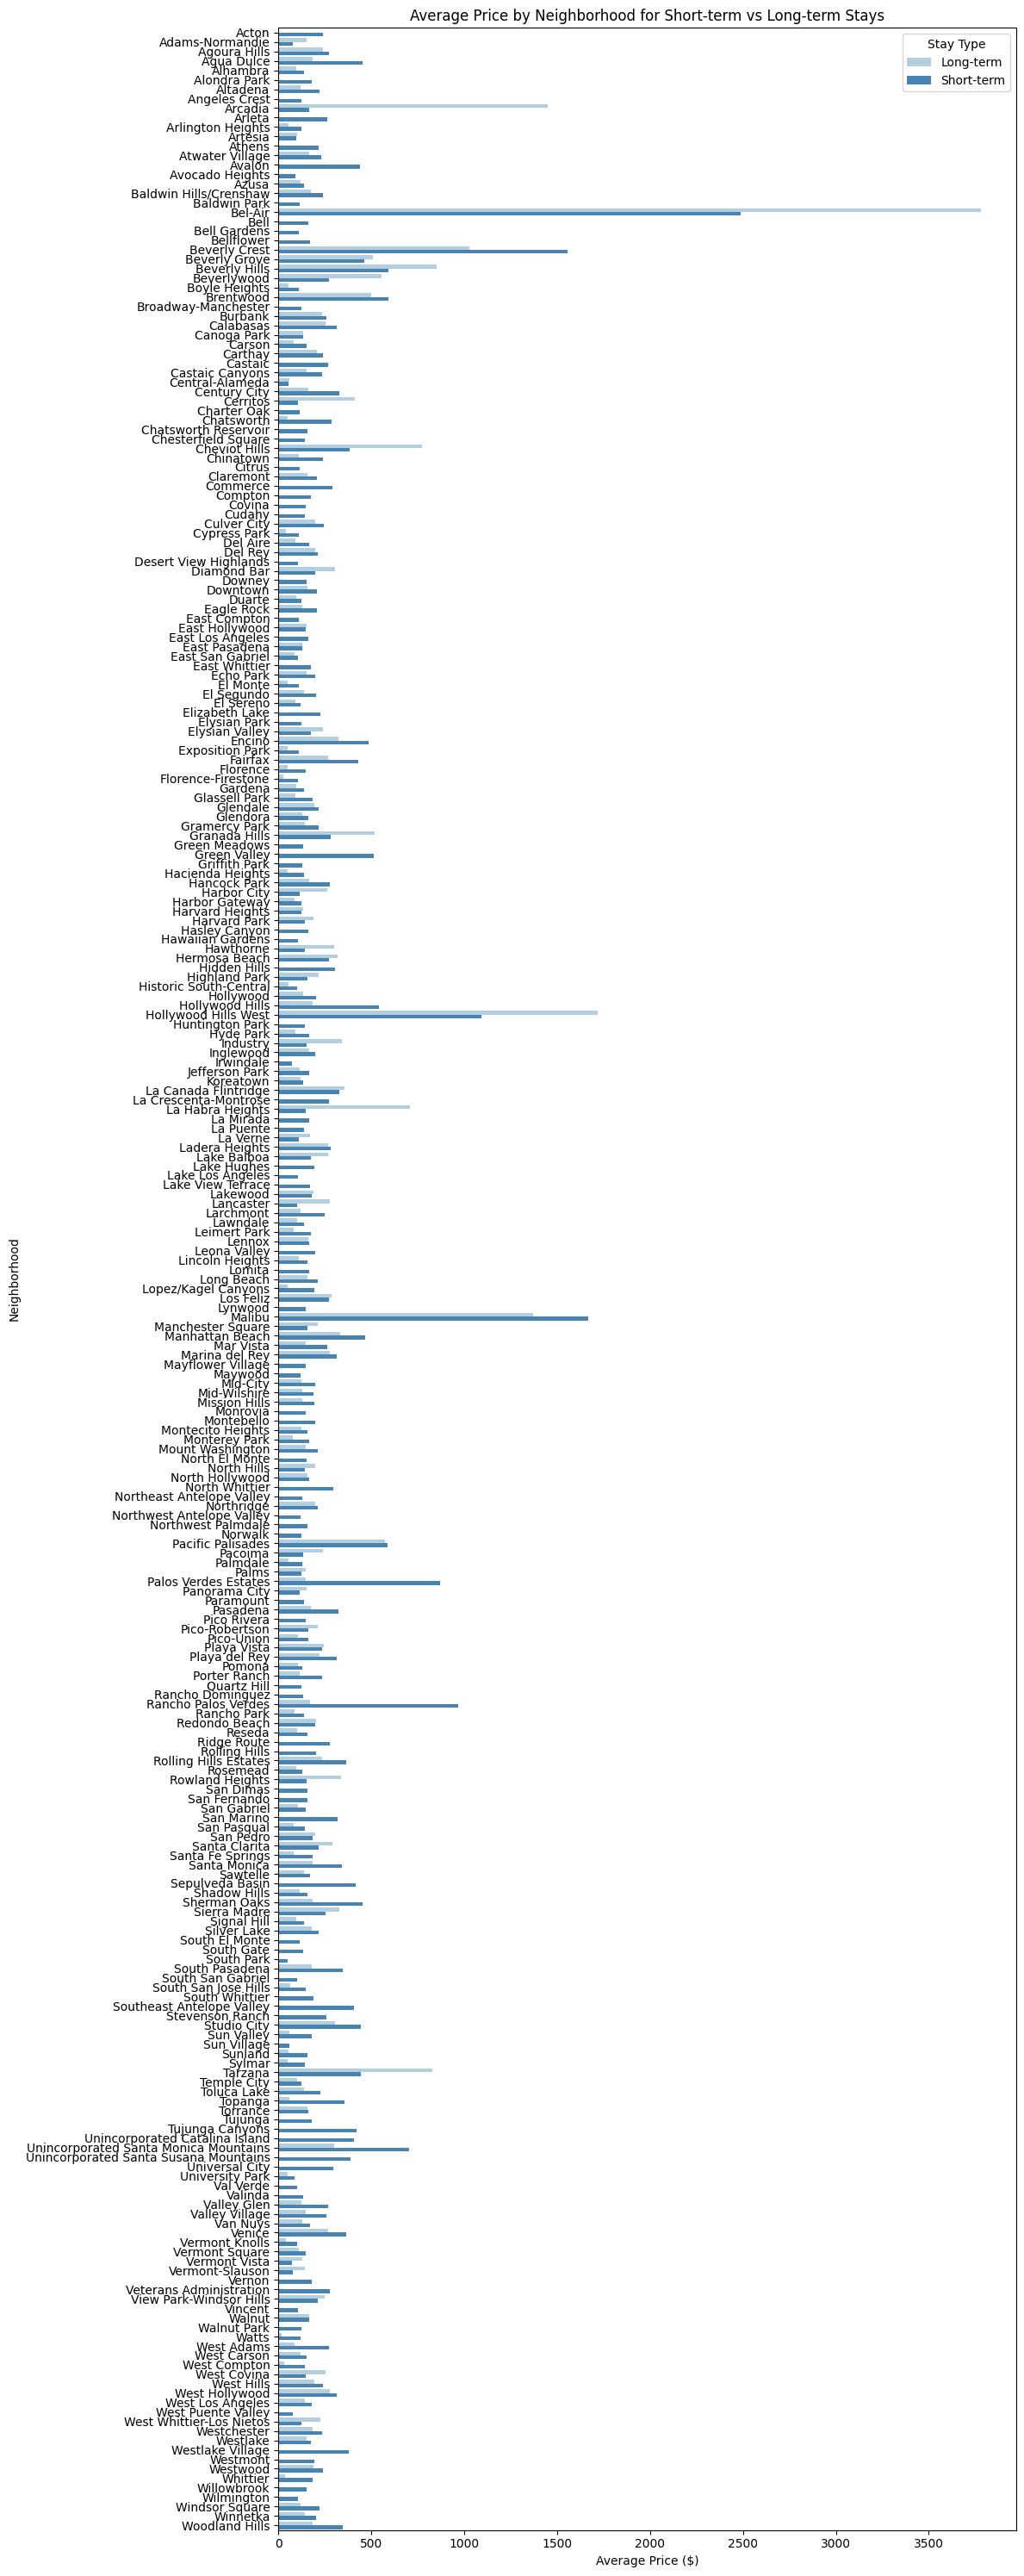

In [86]:
# Plotting average price by neighborhood for short-term and long-term stays
plt.figure(figsize=(12, 30))

# Preparing data for the plot
avg_price_neighbourhood_stay_type_reset = avg_price_neighbourhood_stay_type.reset_index().melt(id_vars='neighbourhood_cleansed',
                                                                                                       var_name='stay_type',
                                                                                                       value_name='average_price')

# Average price by neighborhood for short-term and long-term stays
sns.barplot(data=avg_price_neighbourhood_stay_type_reset,
            x='average_price',
            y='neighbourhood_cleansed',
            hue='stay_type',
            palette='Blues')
plt.title('Average Price by Neighborhood for Short-term vs Long-term Stays')
plt.xlabel('Average Price ($)')
plt.ylabel('Neighborhood')
plt.legend(title='Stay Type')

plt.tight_layout()
plt.show()

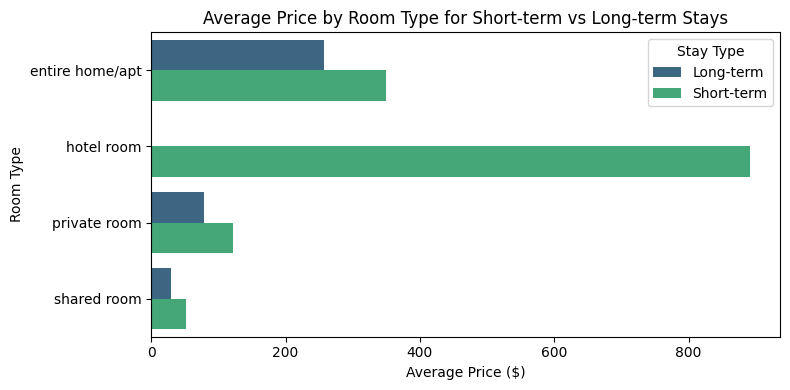

In [87]:
# Plotting average price by room type for short-term and long-term stays
plt.figure(figsize=(8, 4))

# Preparing data for the plot
avg_price_room_type_stay_type_reset = avg_price_room_type_stay_type.reset_index().melt(id_vars='room_type',
                                                                                           var_name='stay_type',
                                                                                           value_name='average_price')

# Average price by room type for short-term and long-term stays
sns.barplot(data=avg_price_room_type_stay_type_reset,
            x='average_price',
            y='room_type',
            hue='stay_type',
            palette='viridis')
plt.title('Average Price by Room Type for Short-term vs Long-term Stays')
plt.xlabel('Average Price ($)')
plt.ylabel('Room Type')
plt.legend(title='Stay Type')

plt.tight_layout()
plt.show()


# 5. Neighborhood Comparison

Compare the average review_scores_rating across different neighborhoods. Determine if certain neighborhoods have consistently higher ratings, which could indicate better or worse guest experiences.

<ipython-input-88-198322a444db>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_neighbourhood.values, y=avg_rating_neighbourhood.index, palette='viridis')


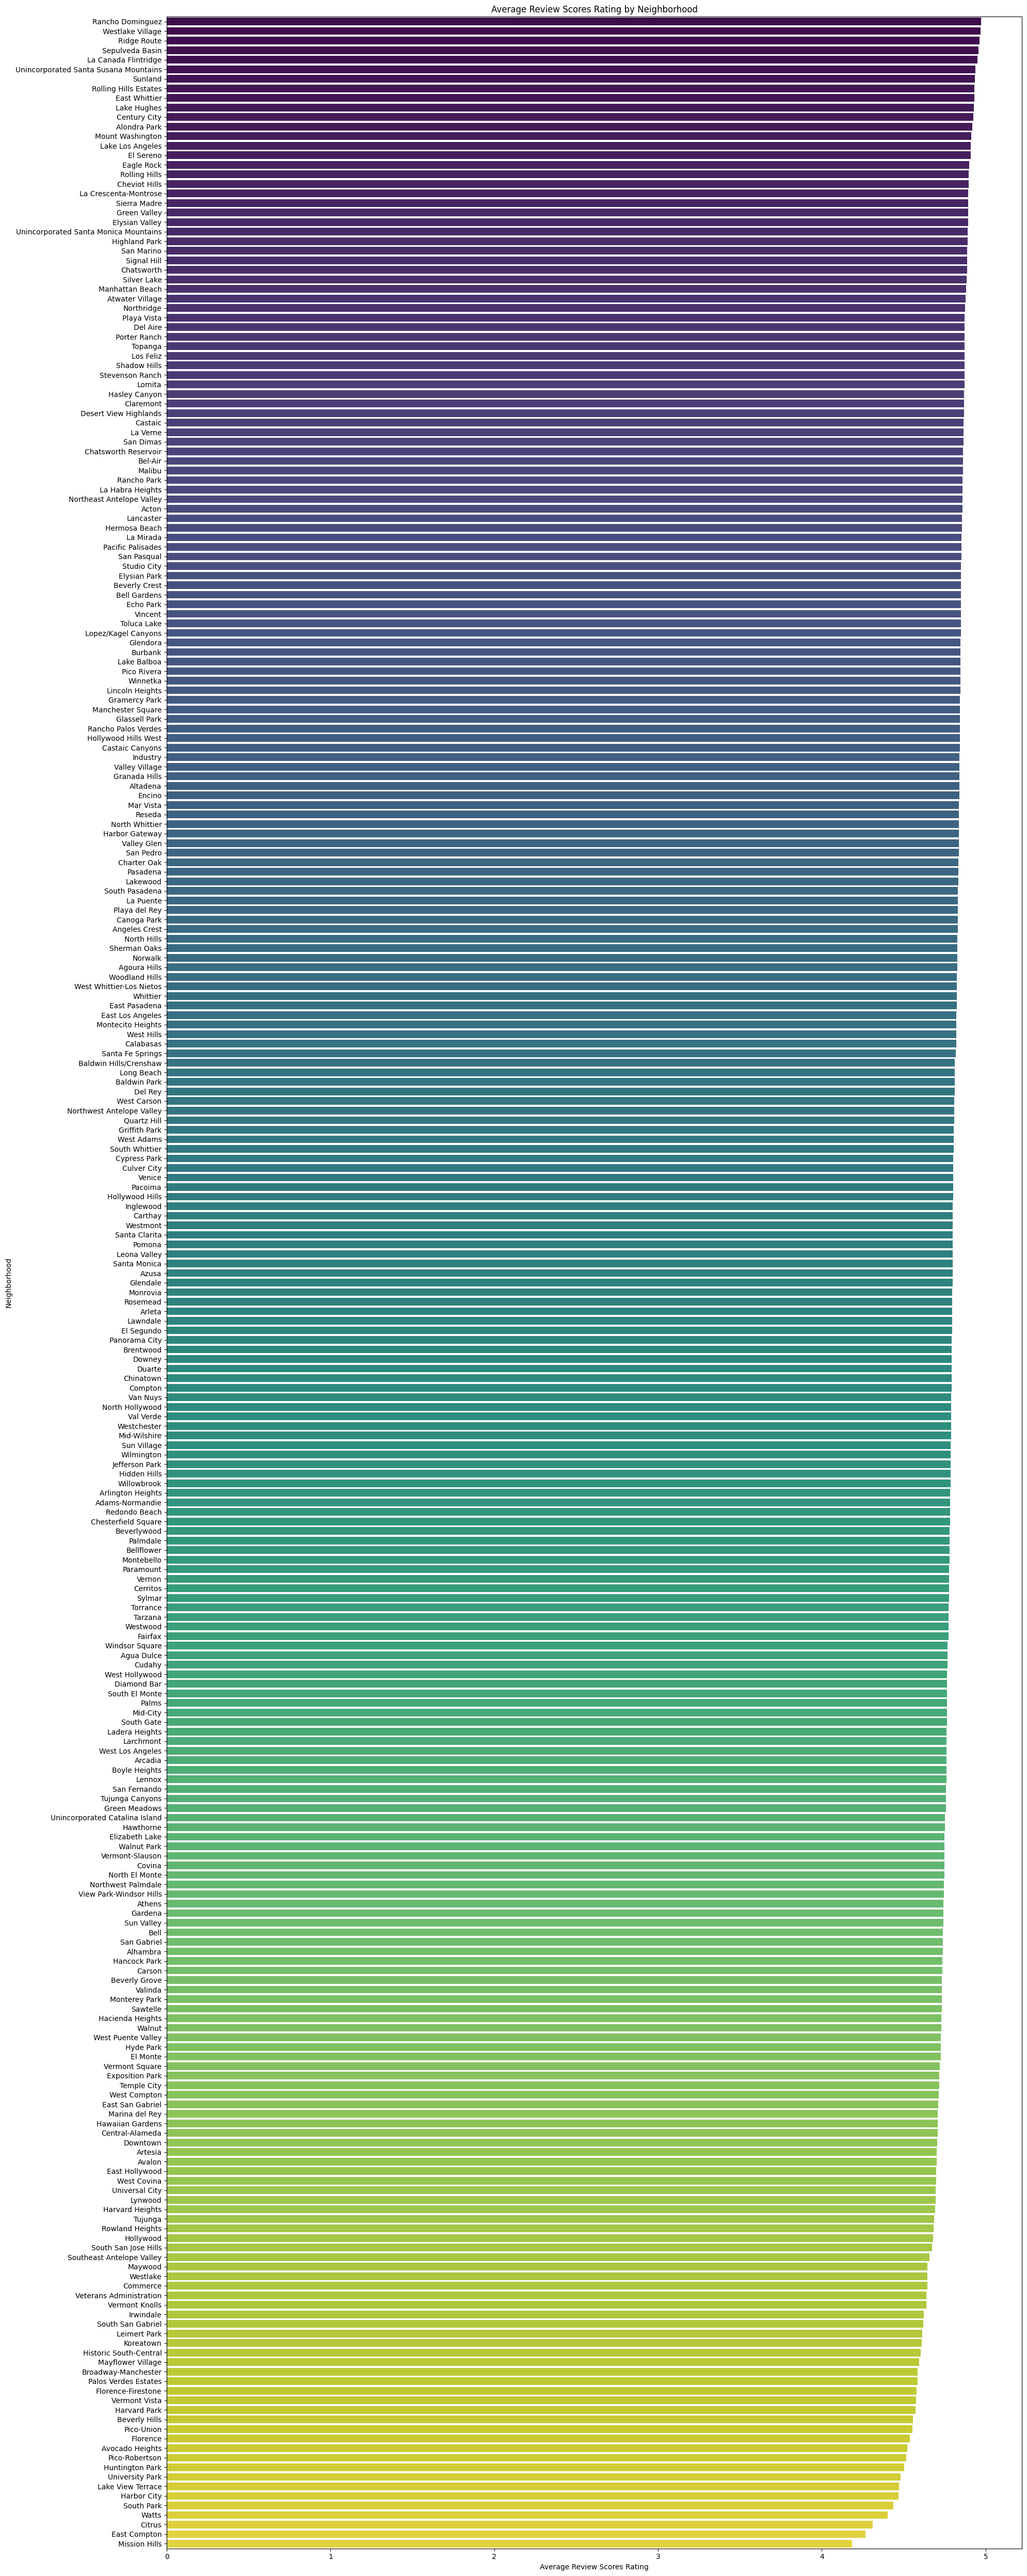

Average Review Scores Rating by Neighborhood:
neighbourhood_cleansed
Rancho Dominguez        4.972500
Westlake Village        4.968000
Ridge Route             4.962000
Sepulveda Basin         4.957500
La Canada Flintridge    4.950857
                          ...   
South Park              4.436154
Watts                   4.400800
Citrus                  4.310000
East Compton            4.265000
Mission Hills           4.185833
Name: review_scores_rating, Length: 265, dtype: float64


In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculating average review_scores_rating per neighborhood
avg_rating_neighbourhood = listings.groupby('neighbourhood_cleansed')['review_scores_rating'].mean().dropna().sort_values(ascending=False)

# Plotting the average review_scores_rating across neighborhoods with seaborn
plt.figure(figsize=(20, 50))
sns.barplot(x=avg_rating_neighbourhood.values, y=avg_rating_neighbourhood.index, palette='viridis')

plt.title('Average Review Scores Rating by Neighborhood')
plt.xlabel('Average Review Scores Rating')
plt.ylabel('Neighborhood')

plt.tight_layout()
plt.show()

# Display the average review scores rating per neighborhood
print("Average Review Scores Rating by Neighborhood:")
print(avg_rating_neighbourhood)


# 6. Outlier Detection

Identify outliers in the dataset, particularly in price, minimum_nights, and review_scores_rating.

# Detecting outliers using IQR

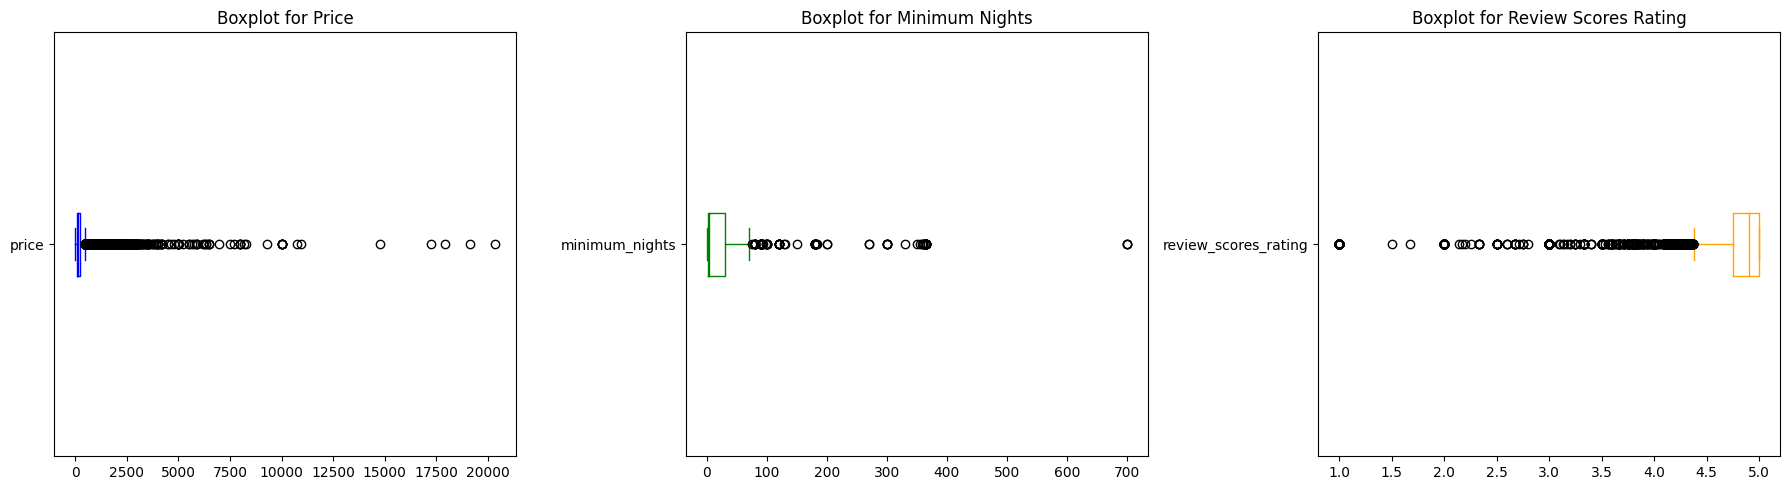

Number of price outliers: 3522
        price
7      1179.0
8      1244.0
20     1080.0
37     6210.0
45     1325.0
...       ...
45396  1019.0
45397   511.0
45400   549.0
45413   520.0
45511   725.0

[3522 rows x 1 columns]

Number of minimum nights outliers: 446
       minimum_nights
105               181
113               200
117               365
123               175
263                90
...               ...
44950             180
44998             180
45197             365
45239              90
45475             180

[446 rows x 1 columns]

Number of review scores rating outliers: 2160
       review_scores_rating
3                       3.0
27                      2.5
48                      1.0
60                      3.8
72                      1.0
...                     ...
45441                   4.0
45469                   4.2
45473                   4.0
45507                   1.0
45517                   1.0

[2160 rows x 1 columns]


In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# List of columns to check for outliers
outlier_columns = ['price', 'minimum_nights', 'review_scores_rating']

# Function to detect outliers using IQR
def detect_outliers_iqr(listings_1, column):
    Q1 = listings[column].quantile(0.25)
    Q3 = listings[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = listings[(listings[column] < lower_bound) | (listings[column] > upper_bound)]
    return outliers

# Detecting outliers for each column
outliers_price = detect_outliers_iqr(listings_1, 'price')
outliers_minimum_nights = detect_outliers_iqr(listings_1, 'minimum_nights')
outliers_review_scores = detect_outliers_iqr(listings_1, 'review_scores_rating')

# Visualizing outliers with boxplots
plt.figure(figsize=(18, 5))

# Boxplot for price
plt.subplot(1, 3, 1)
listings_1['price'].plot(kind='box', vert=False, color='blue')
plt.title('Boxplot for Price')

# Boxplot for minimum nights
plt.subplot(1, 3, 2)
listings_1['minimum_nights'].plot(kind='box', vert=False, color='green')
plt.title('Boxplot for Minimum Nights')

# Boxplot for review scores rating
plt.subplot(1, 3, 3)
listings_1['review_scores_rating'].plot(kind='box', vert=False, color='orange')
plt.title('Boxplot for Review Scores Rating')

plt.tight_layout()
plt.show()

# Display the outliers
print(f"Number of price outliers: {len(outliers_price)}")
print(outliers_price[['price']])

print(f"\nNumber of minimum nights outliers: {len(outliers_minimum_nights)}")
print(outliers_minimum_nights[['minimum_nights']])

print(f"\nNumber of review scores rating outliers: {len(outliers_review_scores)}")
print(outliers_review_scores[['review_scores_rating']])

# Outlier Detection using Z Score Technique  

Number of outliers detected: 1244
        price  minimum_nights  review_scores_rating
3        49.0               1                   3.0
27       30.0              30                   2.5
37     6210.0              30                   5.0
48       80.0              30                   1.0
72       80.0               1                   1.0
...       ...             ...                   ...
45400   549.0               1                   3.0
45434     NaN              30                   3.0
45475     NaN             180                   NaN
45507     NaN              30                   1.0
45517     NaN               1                   1.0

[1244 rows x 3 columns]


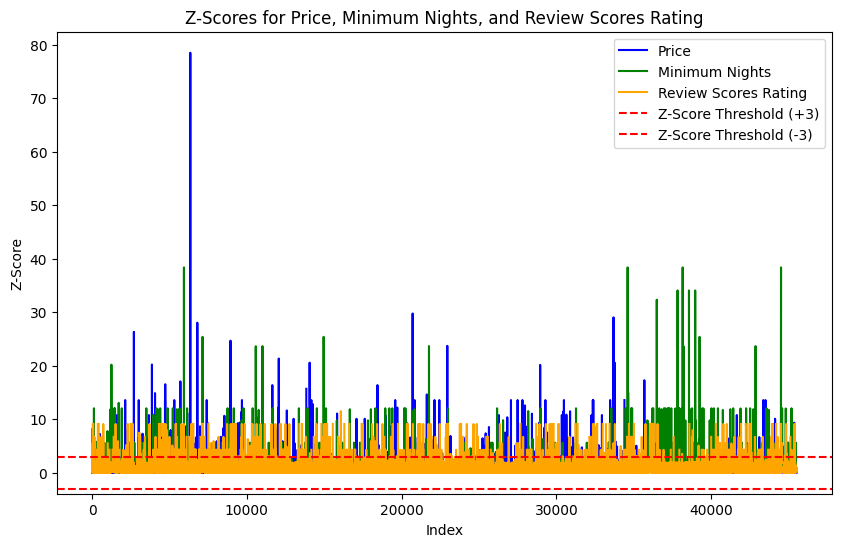

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# List of columns to check for outliers
outlier_columns = ['price', 'minimum_nights', 'review_scores_rating']

# Standardizing (z-scoring) the data for outlier detection
z_scores = np.abs((listings[outlier_columns] - listings[outlier_columns].mean()) / listings[outlier_columns].std())

# Detecting outliers with a z-score threshold of 3
outliers = listings[(z_scores > 3).any(axis=1)]

# Checking for outliers in specific columns
print(f"Number of outliers detected: {len(outliers)}")
print(outliers[outlier_columns])

# Plotting the z-scores with colors for each property
plt.figure(figsize=(10, 6))

# Plot each property with a different color
plt.plot(z_scores['price'], label='Price', color='blue')
plt.plot(z_scores['minimum_nights'], label='Minimum Nights', color='green')
plt.plot(z_scores['review_scores_rating'], label='Review Scores Rating', color='orange')

# Add z-score threshold line at 3 and -3
plt.axhline(y=3, color='red', linestyle='--', label='Z-Score Threshold (+3)')
plt.axhline(y=-3, color='red', linestyle='--', label='Z-Score Threshold (-3)')

# Add labels and title
plt.title('Z-Scores for Price, Minimum Nights, and Review Scores Rating')
plt.xlabel('Index')
plt.ylabel('Z-Score')

# Add legend to show which color represents which property
plt.legend()

# Show the plot
plt.show()
